# Libraries

In [419]:
import tqdm
import spacy
import numpy as np
import regex as re
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import pyLDAvis.gensim_models as gensimvis

import gensim
# from gensim.models import wrappers
# from gensim.models.wrappers import LdaMallet
import gensim.corpora as corpora
from gensim.corpora import dictionary
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# Think these can be removed
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

# Importing -- Fixing columns

In [2]:
full = pd.read_csv('../Data/Data-Cleaned/238k-Uncleaned')

In [3]:
# Renaming tweets column, dropping unnamed column, making tweets strings

full['tweets'] = full['0']
full.reset_index(inplace = True)
full = full.drop(columns = ['0', 'Unnamed: 0', 'index'])
# eh
full.drop_duplicates(inplace = True, ignore_index = True)

# Preprocessing ---- 

In [220]:
# Function for Gensim simple preprocessor --- 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
# STOPWORDS ==========================================
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words]for doc in texts]
# Stop Words list -- Can be Edited
stop_words = stopwords.words('english')
# stop_words.extend(['tesla', 'c,', 'x', 't', 'p', 'amp', 'car', 'get', 'go', 'use'])
stop_words.extend(['tesla', 'c,', 'x', 't', 'p', 'amp', 'car',
                   'get', 'go', 'use', 'elon', 'musk', 'elon_musk'])
wnl = WordNetLemmatizer()

# BIGRAMS===============================================
def make_bigrams(texts):
    return bigram_mod[texts]

# TRIGRAMS =============================================
def make_trigrams(texts):
    return trigram_mod[bigram_mod[texts]]

# LEMMATIZING ==========================================
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None    
def lemmatize_texts(tweet):
     for i in tweet:
        word = (map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet))) 
        word_lem = " ".join([wnl.lemmatize(x[0], x[1]) for x in word if x[1] is not None])
        return word_lem

In [221]:
# remove punctuation and lowercase all
full['preprep'] = full['tweets'].map(lambda x: re.sub('[,\.!?]', '', x.lower()))
#  Removing @ handles, links-- strip whitespace breaks and tabs
full['preprep'] = full['preprep'].map(lambda x: re.sub(r"@\w+|http\S+", "", x).strip()\
                                      .replace("\r", "").replace("\n", "").replace("\t", ""))

In [222]:
# Creates a list of all tweets in full.preprep
data = full.preprep.values.tolist()

# Uses gensims simple preprocessor on all tweets in list
# Ouputs list of lists of tokenized tweets
data_words = list(sent_to_words(data))

In [223]:
# Bigram ---
# higher hyperparameter values =  fewer phrases.
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # orig -- 3/ 75
bigram_mod = gensim.models.phrases.Phraser(bigram)

# TriGrams --
trigram = gensim.models.Phrases(bigram[data_words], threshold=60)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [224]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# lemmatize
data_lemmatized = [lemmatize_texts(tweet) for tweet in data_words_bigrams]

In [393]:
# Getting indices of all nones
indices_of_nones = [(i) for i,x  in enumerate(data_lemmatized) if x == None]
len(indices_of_nones)

# Dropping None values using indices aquired above
lem_drop_None = [(i, x) for (i, x) in enumerate(data_lemmatized) if i not in indices_of_nones]
len(lem_drop_None)

# Getting indices of all short tweets
indices_short_tweets = [i for (i,x) in lem_drop_None if (len(x.split(' ')) <= 5)]
len(indices_short_tweets)

# Dropping short tweets  
lem_noShort_noNone = [(i, x) for (i, x) in lem_drop_None if i not in indices_short_tweets]
len(lem_noShort_noNone)

lem_noNone = [x.split() for (i, x) in lem_noShort_noNone]

print('data_lemmatized Length: ', len(data_lemmatized), 
      '\n Number of Nones created from lemmatizing: ', len(indices_of_nones), 
      '\n Doc count without Nones: ', len(lem_drop_None), 
      '\n Number of Docs shorter than 5 words: ',  len(indices_short_tweets), 
      '\n Number of Docs dropping short documents: ', len(lem_noShort_noNone) )

data_lemmatized Length:  126510 
 Number of Nones created from lemmatizing:  384 
 Doc count without Nones:  126126 
 Number of Docs shorter than 5 words:  38518 
 Number of Docs dropping short documents:  87608


In [409]:
id2word = corpora.Dictionary(lem_noNone)
print('Number of Unique tokens: ', len(id2word)) 

Number of Unique tokens:  62499


In [410]:
# This can be Tuned --- and probably should be
id2word.filter_extremes(no_below=15, no_above=.90)
print('Unique tokens after filtering Corpus: ', len(id2word))

Unique tokens after filtering Corpus:  6768


In [411]:
corpus = [id2word.doc2bow(d) for d in lem_noNone]

## The Rosetta Stone

In [412]:
print(       (lem_noNone[8654]), 
      '\n\n',(lem_noShort_noNone[8654]), 
      '\n\n',(full.preprep.iloc[13142]), 
      '\n\n',(full.tweets.iloc[13142]))

['count', 'stack', 'racial', 'lawsuit', 'fill', 'twitter', 'mostly', 'emotion', 'speculator'] 

 (13374, 'count stack racial lawsuit fill twitter mostly emotion speculator') 

 i’ve been wondering how elon’s antics are going to affect tesla’s bottom line conservatives prefer fossil fuel vehicles and lots of liberal buyers are no doubt looking elsewhere for an electric vehicle 

 @BriannaWu I’ve been wondering how Elon’s antics are going to affect Tesla’s bottom line? Conservatives prefer fossil fuel vehicles, and lots of liberal buyers are no doubt looking elsewhere for an electric vehicle.


# Modeling

In [413]:
# Instantiating a Base LDA model
base_model = LdaMulticore(corpus=corpus,
                          num_topics=5,
                          id2word=id2word,
                          workers=7,
                          passes=5,
                          chunksize=2000,
                          random_state = 42)
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
topics = [' '.join(t[0:10]) for t in words]

for id, t in enumerate(topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
stock twitter price buy market share sell tsla company spot

------ Topic 2 ------
find stock free twitter say enter try pay tweet take

------ Topic 3 ------
car make company ev battery fire vehicle driver say also

------ Topic 4 ------
buy world think go know come company electric ev say

------ Topic 5 ------
make people buy car want think electric_car know even say



In [414]:
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=lem_noNone, 
                                   dictionary=id2word, coherence='c_v')

coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base, '\n\nPerplexity: ', base_perplexity)


Coherence Score:  0.29228020370920016 

Perplexity:  -7.591629622327501


In [415]:
newer_model = LdaMulticore(corpus=corpus,
                          num_topics=8,
                          id2word=id2word,
                          workers=6,
                          passes=20,
                          alpha = 0.909 , 
                          eta = 0.01,
                          chunksize=1500,
                          random_state = 100)
newer_words = [re.findall(r'"([^"]*)"',t[1]) for t in newer_model.print_topics()]
newer_topics = [' '.join(t[0:10]) for t in newer_words]

for id, t in enumerate(newer_topics): 
    print(f"------ Topic {id + 1} ------")
    print(t, end="\n\n")

------ Topic 1 ------
make fire model first new spot take ford bad someone

------ Topic 2 ------
say company spacex call ceo want tweet part best reason

------ Topic 3 ------
ev battery electric_car company build help power also run new

------ Topic 4 ------
stock buy twitter sell go price money back market share

------ Topic 5 ------
year time well many much come still world big high

------ Topic 6 ------
even get look right thing know start give way point

------ Topic 7 ------
car need electric drive vehicle find people charge free love

------ Topic 8 ------
think people know day see work crash guy really read



In [416]:
# a measure of how good the model is. lower the better
new_perplexity = newer_model.log_perplexity(corpus)

# Compute Coherence Score
coherence_model = CoherenceModel(model=newer_model, texts=lem_noNone, 
                                   dictionary=id2word, coherence='c_v')

coherence_lda_model_new = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_new, '\n\nPerplexity: ', new_perplexity)


Coherence Score:  0.35586444476703905 

Perplexity:  -8.964735511627824


In [417]:
pyLDAvis.enable_notebook()
gensimvis.prepare(newer_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.016099  0.272311       1        1  13.849085
4      0.066063 -0.020291       2        1  13.119126
2      0.290952 -0.101675       3        1  12.960524
7     -0.243322  0.020339       4        1  12.828222
5     -0.197839 -0.086536       5        1  12.605689
6     -0.105860 -0.095334       6        1  12.015780
1      0.127565  0.248143       7        1  11.885348
0      0.078540 -0.236957       8        1  10.736226, topic_info=         Term          Freq         Total Category  logprob  loglift
108     stock  12601.000000  12601.000000  Default  30.0000  30.0000
101       buy  10884.000000  10884.000000  Default  29.0000  29.0000
144      make   9469.000000   9469.000000  Default  28.0000  28.0000
112       car   9052.000000   9052.000000  Default  27.0000  27.0000
56      think   6298.000000   6298.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1583     tech    754.942340   1169.740050   Topic8  -4.9630   1.7937
20    already    780.733493   1489.365827   Topic8  -4.9294   1.5857
845    anyone    689.442082   1037.950836   Topic8  -5.0537   1.8224
72       know    781.495185   5421.544639   Topic8  -4.9284   0.2946
221      good    759.333911   4217.283401   Topic8  -4.9572   0.5170

[543 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3194      2  0.998500  accelerate
10        7  1.000747      accord
314       1  0.006848    actually
314       2  0.032373    actually
314       3  0.003735    actually
...     ...       ...         ...
226       7  0.002207        yeah
226       8  0.110336        yeah
264       2  0.999624        year
264       3  0.000263        year
2881      5  0.998315     youtube

[1337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 8, 6, 7, 2, 1])

In [358]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



In [359]:
# Every Tweet Classified by Dominant Topic
df_topic_sents_keywords = format_topics_sentences(ldamodel = newer_model,
                                                  corpus = corpus,
                                                  texts = lem_noNone)

In [360]:
sent_topics_Sorteddf = pd.DataFrame()
sent_topics_Outdf = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, group in sent_topics_Outdf:
    sent_topics_Sorteddf = pd.concat([sent_topics_Sorteddf, 
                                             group.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_Sorteddf.reset_index(drop=True, inplace=True)
# Format
sent_topics_Sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]



In [361]:
sent_topics_Sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.7324,"stock, buy, twitter, sell, price, back, go, pa...","[already, say, back, buy, stock, raise, price,..."
1,1,0.6777,"car, make, ev, electric, new, well, vehicle, b...","[sell, emyes, saic_mg, tata, capable, range, p..."
2,2,0.7386,"time, year, money, give, day, model, let, say,...","[breaking_news, btc, crypto_binance, altcoins,..."
3,3,0.7082,"drive, even, use, love, driver, sure, make, pr...","[tnr_gold, mariana_lithium, nsr_royalty, partn..."
4,4,0.6949,"need, fire, first, charge, spot, open, door, p...","[digital_everything, starlink, bitcoin_riyadh,..."
5,5,0.6881,"see, say, know, thing, really, spacex, guy, wo...","[article, say, invite, uaw, unionize, worker, ..."
6,6,0.7376,"company, never, tsla, look, big, world, happen...","[steve_harvey, pure_evilhate, whites_rob, blac..."
7,7,0.6432,"people, think, good, electric_car, want, buy, ...","[government_agent, inject_dean, neurotrophic_d..."


In [362]:
def original_tweet_sentiment(cleaned_to_index, original, cleaned_to_topic):
    comp_dic = {}
    sia = SentimentIntensityAnalyzer()
    
    for i in range(len(cleaned_to_index)):
        ind = cleaned_to_index[i][0]
        tweet = original.iloc[ind]
        comp_dic[i] = tweet, sia.polarity_scores(tweet)['compound']
        
    comp_scores = pd.DataFrame(comp_dic).T
    comp_scores.columns = ['Original_tweet', 'Sentiment']
    
    df_sent = cleaned_to_topic.merge(comp_scores, left_index = True, right_index = True)
    
    return df_sent

In [392]:
df_sent = original_tweet_sentiment(lem_noShort_noNone, full['tweets'],df_topic_sents_keywords )

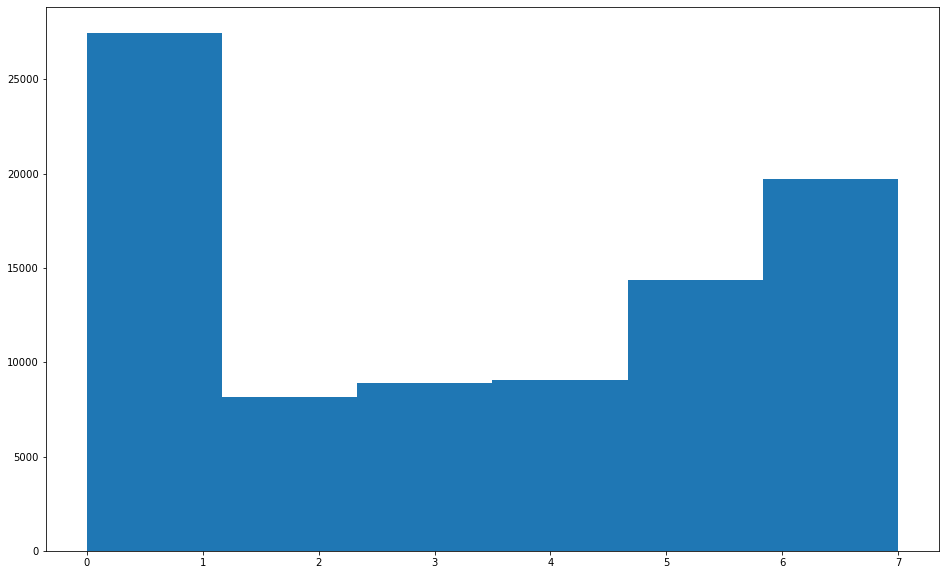

In [418]:
# Topic Distributions VISUALIZATION
topic_dist = pd.Series(df_topic_sents_keywords.Dominant_Topic, dtype = 'category')
# sns.countplot(topic_dist)
fix, ax = plt.subplots(figsize = (16, 10))
plt.hist(topic_dist, bins = 6);

#### ============================================================================

# Below is the grid search the chunky one

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=1500,
                                           passes=8,
                                           alpha=a,
                                           eta=b, 
                                           workers = 7)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lem_noNone, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 9
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [#gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.5)), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['50% Corpus', '75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    results_df = pd.DataFrame(model_results)
    pbar.close()

In [33]:
results_df = pd.read_csv('Data/first-gs-results-24h')
results_df.drop(columns = 'Unnamed: 0', inplace = True)

In [34]:
results_df[(results_df['Coherence'] >= 0.38) & (results_df['Topics'] == 5 )]

,Validation_Set,Topics,Alpha,Beta,Coherence
240,75% Corpus,5,0.01,0.01,0.384454
245,75% Corpus,5,0.31,0.01,0.381647
260,75% Corpus,5,symmetric,0.01,0.380380
420,100% Corpus,5,0.01,0.01,0.381210
430,100% Corpus,5,0.61,0.01,0.384243
440,100% Corpus,5,symmetric,0.01,0.389232


# =============================================================================

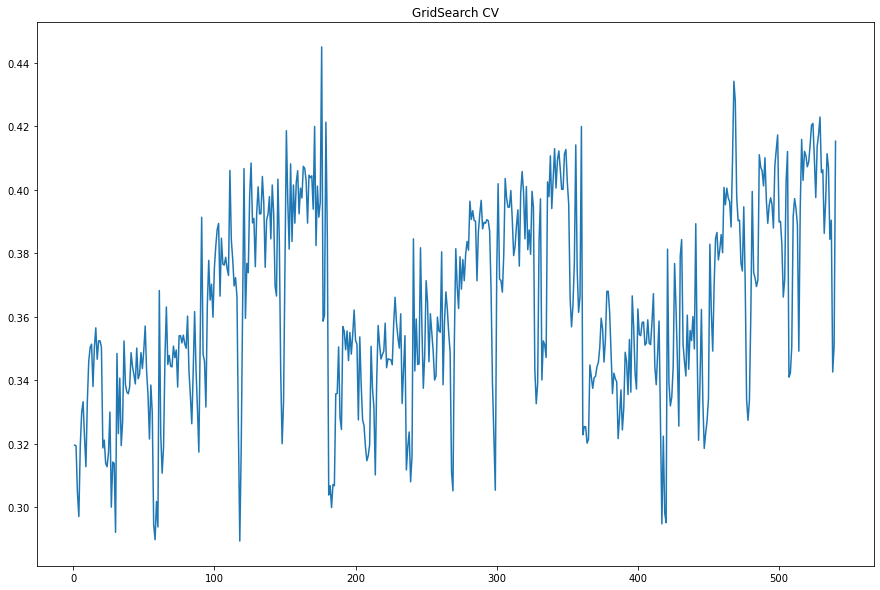

In [351]:
# sns.lineplot(x= range(len(results_df['Coherence'])), y = results_df['Coherence'])

fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(np.linspace(1, 540, 540),'Coherence', data = results_df )
ax.set_title('GridSearch CV');

Text(0.5, 1.0, 'Topics')

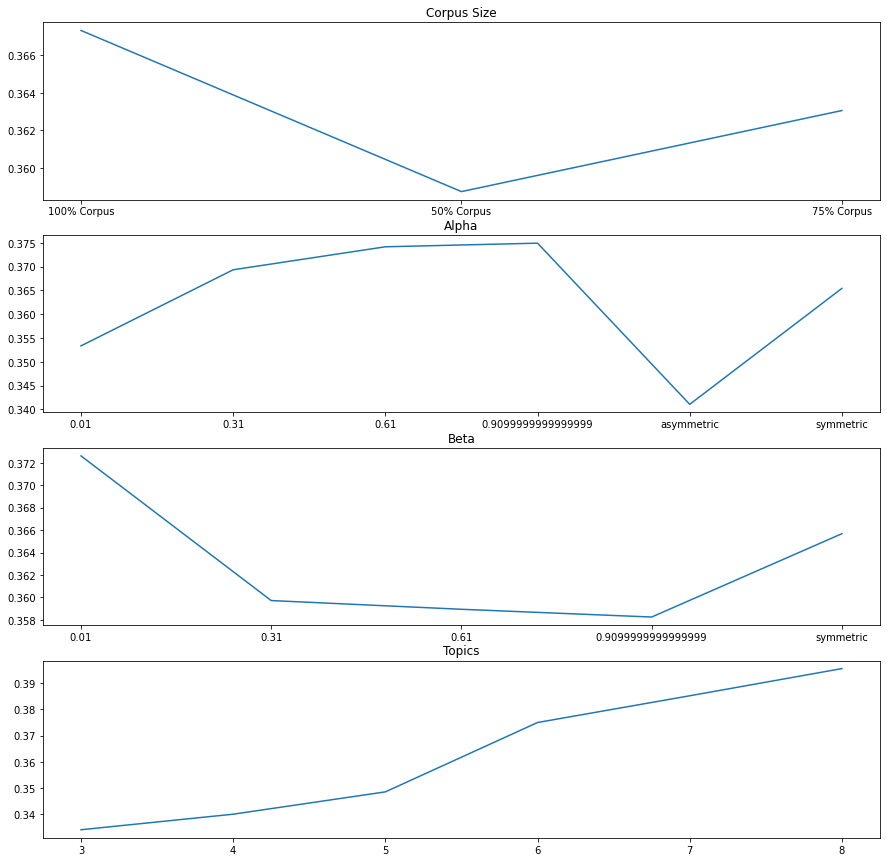

In [335]:

ax1_df = results_df.Coherence.groupby(by=results_df['Validation_Set']).mean()
ax2_df = results_df.Coherence.groupby(by=results_df['Alpha']).mean()
ax3_df = results_df.Coherence.groupby(by=results_df['Beta']).mean()
ax4_df = results_df.Coherence.groupby(by=results_df['Topics']).mean()


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1 , figsize = (15, 15))




ax1.plot(ax1_df)
ax1.set_title('Corpus Size')

ax2.plot(ax2_df)
ax2.set_title('Alpha')

ax3.plot(ax3_df)
ax3.set_title('Beta')

ax4.plot(ax4_df)
ax4.set_title('Topics')